In [1]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [90]:
def toy_data():
    data = torch.rand((100, 100), device=device)
    data[data < 0.95] = 0
    data[10:45, 0:15] = torch.rand((35, 15), device=device) * 40
    data[30:90, 30:85] = torch.rand((60, 55), device=device) * 40
    data[85:95, 85:95] = torch.rand((10, 10), device=device) * 40
    
    return data

In [91]:
data = toy_data()

In [397]:
epochs = 2
start_point = torch.tensor(0.3, device=device)
end_point = torch.tensor(1.0, device=device)

n = 13
params = torch.rand(size=(1, n * 2 + 2), requires_grad=True).to(device)
reg_loss = nn.SmoothL1Loss()
# optimizer = optim.Adam([params], lr=1e-3)
optimizer = optim.LBFGS([params], lr=1e-5)
optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

w =  data.shape[1]
delta = 1 / data.shape[0]
t = torch.linspace(start=0, end=1, steps=data.shape[0], device=device)
t = torch.cat([torch.ones_like(t[..., None])] + [t[..., None] ** i for i in range(1, n + 1)], dim=1)
loss_history = []

rand_y = torch.rand_like(t[:, 0])
rand_y[0] = start_point
rand_y[-1] = end_point

for epoch in range(epochs):
    
#     print(params)
    
    def closure():
        optimizer.zero_grad()
        y = (t * params[0, :n+1]).sum(axis=1).view(-1)
        z = (t * params[0, n+1:]).sum(axis=1).view(-1)
        loss = (torch.abs(y[0] - start_point) + torch.abs(y[-1] - end_point)) * 1e3

        target_y = rand_y.clamp(0, 1 - 1/w)
        index = torch.tensor(target_y * w, requires_grad=False, dtype=torch.long, device=device)
        target_z = torch.gather(data, 1, index[..., None]).view(-1)

        length = torch.sqrt(delta ** 2 + (y[1:] - y[:-1]) ** 2 + (z[1:] - z[:-1]) ** 2).mean()
        loss += length

        loss += reg_loss(y, rand_y) +  reg_loss(z, target_z)

        loss.backward()
        loss_history.append(loss.item())
        return loss

    optimizer.step(closure)
        
#     print(params)

#     for _ in range(20):
#         y = (t * params[0, :n+1]).sum(axis=1).view(-1)
#         z = (t * params[0, n+1:]).sum(axis=1).view(-1)
#         optimizer.zero_grad()
    
#         loss = (torch.abs(y[0] - start_point) + torch.abs(y[-1] - end_point) + torch.abs(z[0] - data[0, 0]) + torch.abs(z[-1] - data[-1, -1])) * 1e-3
#         length = torch.sqrt(delta ** 2 + (y[1:] - y[:-1]) ** 2 + (z[1:] - z[:-1]) ** 2).mean()
#         loss += length

#         loss.backward()
#         optimizer.step()

/home/robo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [398]:
y = (t * params[0, :n+1]).sum(axis=1).view(-1).detach().cpu().numpy()
z = (t * params[0, n+1:]).sum(axis=1).view(-1).detach().cpu().numpy()
y[0], y[-1], z[0], z[-1], data[0, 0], data[-1, -1]

(0.2854641, 0.9242954, 0.9229486, 6.5962963, tensor(0.9910), tensor(0.))

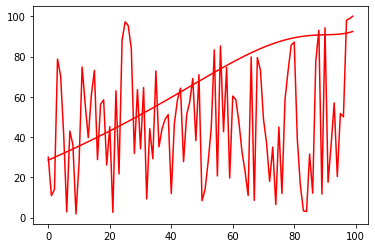

In [399]:
plt.plot(y * w, 'r')
plt.plot(rand_y.numpy() * w, 'r')

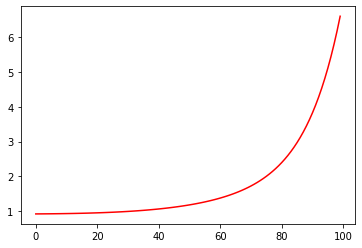

In [400]:
plt.plot(z, 'r')

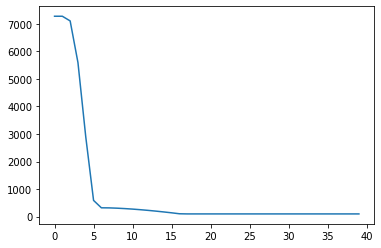

In [401]:
plt.plot(loss_history)

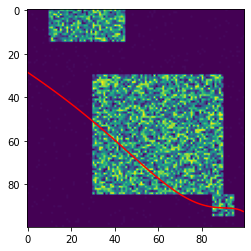

In [402]:
plt.imshow(data.cpu().numpy().transpose(1, 0))
plt.plot(y * w, 'r')

In [403]:
np.sqrt(delta ** 2 + (y[1:] - y[:-1]) ** 2 + (z[1:] - z[:-1]) ** 2).sum()

6.2045755